In [1]:
#!/usr/bin/python
# -*- coding: latin-1 -*-
"""
This notebook generates the statistics and galleries for the first round
of WLE in a given YEAR.

The behavior of the notebook is ruled by two variables:
- YEAR (int): the year the statistics refer to.
- update_images (boolean): it determines whether images have to be uploaded.
Once the images have been uploaded, it is not expected new versions are
needed.
"""
import os, sys, inspect
current_folder = os.path.realpath(os.path.abspath(os.path.split(inspect.getfile(inspect.currentframe()))[0]))
folder_parts = current_folder.split(os.sep)
pywikibot_folder = os.sep.join(folder_parts[0:-1])
if current_folder not in sys.path:
    sys.path.insert(0, current_folder)
if pywikibot_folder not in sys.path:
    sys.path.insert(0, pywikibot_folder)

import pywikibot as pb
from pywikibot import pagegenerators
from pywikibot.specialbots import UploadRobot
from StringIO import StringIO
import mwparserfromhell as mwh
from datetime import datetime
import pandas as pd
import numpy as np
from urllib import urlencode, urlopen
import json
from random import sample
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import io
import time
import csv
from itertools import groupby
from operator import itemgetter
from mako.template import Template

In [2]:
sns.set_style("darkgrid")
%matplotlib inline

In [3]:
YEAR                        = 2017
update_images               = False

BASE_SCI_DB_NAME            = u"Commons:Wiki Loves Earth 2016 in Spain"
SCI_DB_PAGE                 = BASE_SCI_DB_NAME + u"/SCI DB"

BASE_WLE_NAME               = u"Commons:Wiki Loves Earth {0} in Spain".format(YEAR)
STATISTICS_PAGE             = BASE_WLE_NAME + u"/Stats"
LOG_PAGE                    = BASE_WLE_NAME + u"/Log"
GALLERY_PAGE_AUTHORS        = BASE_WLE_NAME + u"/Contributors"
GALLERY_PAGE_SITES          = BASE_WLE_NAME + u"/SCIs"
GALLERY_FEATURED_ARTICLES   = BASE_WLE_NAME + u'/QI'

commons_site = pb.Site("commons", "commons")

In [4]:
API_BASE_URL = u'https://commons.wikimedia.org/w/api.php'
API_QUERY_STRING = {"action": "query",
                    "format": "json",
                    "gulimit": "500",
                    "prop": "globalusage",
                    "guprop": "url|namespace",
                    "titles": None
                    }

In [5]:
description = u"""== {{{{int:filedesc}}}} ==
{{{{Information
|description={{{{en|{1}}}}}
|source={{{{own}}}}
|author=[[User:Discasto|Discasto]]
|date={2}
}}}}

{{{{Created with Matplotlib}}}}

== {{{{int:license-header}}}} ==
{{{{self|cc-by-sa-4.0}}}}

[[Category:Photos by User:Discasto]]
[[Category:Wiki Loves Earth {0} in Spain]]"""

In [6]:
annexes = {
   'ES-AN': [u'Anexo:Lugares de importancia comunitaria de Andalucía', 'Andalusia'],
   'ES-AR': [u'Anexo:Lugares de importancia comunitaria de Aragón', 'Aragon'],
   'ES-AS': [u'Anexo:Lugares de importancia comunitaria de Asturias', 'Asturias'],
   'ES-CB': [u'Anexo:Lugares de importancia comunitaria de Cantabria', 'Cantabria'],
   'ES-CM': [u'Anexo:Lugares de importancia comunitaria de Castilla-La Mancha', 'Castile-La Mancha'],
   'ES-CL': [u'Anexo:Lugares de importancia comunitaria de Castilla y León', u'Castile and León'],
   'ES-CT': [u'Anexo:Lugares de importancia comunitaria de Cataluña', 'Catalonia'],
   'ES-MD': [u'Anexo:Lugares de importancia comunitaria de la Comunidad de Madrid', 'Community of Madrid'],
   'ES-VC': [u'Anexo:Lugares de importancia comunitaria de la Comunidad Valenciana', 'Valencian Community'],
   'ES-EX': [u'Anexo:Lugares de importancia comunitaria de Extremadura', 'Extremadura'],
   'ES-IB': [u'Anexo:Lugares de importancia comunitaria de las Islas Baleares', 'Balearic Islands'],
   'ES-CN': [u'Anexo:Lugares de importancia comunitaria de las Islas Canarias', 'Canary Islands'],
   'ES-GA': [u'Anexo:Lugares de importancia comunitaria de Galicia', 'Galicia'],
   'ES-RI': [u'Anexo:Lugares de importancia comunitaria de La Rioja', 'La Rioja'],
   'ES-NC': [u'Anexo:Lugares de importancia comunitaria de Navarra', 'Navarre'],
   'ES-MC': [u'Anexo:Lugares de importancia comunitaria de la Región de Murcia', 'Region of Murcia'],
   'ES-PV': [u'Anexo:Lugares de importancia comunitaria del País Vasco', 'Basque Country'],
   'ES-ML': [u'Anexo:Lugares de importancia comunitaria de Ceuta y Melilla', 'Melilla'],
   'ES-CE': [u'Anexo:Lugares de importancia comunitaria de Ceuta y Melilla', 'Ceuta'],
   'ES-MAGRAMA': [u'Anexo:Lugares de importancia comunitaria del MAGRAMA', 'MAGRAMA']
}

In [7]:
# retrieval of images from the WLE image log
pb.output('Retrieving --> WLE {0} images list from cache'.format(YEAR))
list_page = pb.Page(commons_site, LOG_PAGE)
list_page_text = StringIO(list_page.text[list_page.text.find('\n') + 1:list_page.text.rfind('\n')])
images_df = pd.read_csv(list_page_text,
                        sep=";",
                        index_col=False,
                        names=['image_title', 'uploader', 'days_from_registration', 
                               'timestamp', 'code', 'name', 'community', 'commons_cat', 
                               'lat', 'long'],
                        encoding='utf-8',
                        quoting=csv.QUOTE_NONE)
images_df["timestamp"] = pd.to_datetime(images_df["timestamp"], format="%Y-%m-%d %H:%M:%S")
images_df.set_index(["timestamp"], inplace=True)
images_df['code'].fillna(u'', inplace=True)
images_df['name'].fillna(u'', inplace=True)
images_df['community'].fillna(u'', inplace=True)
images_df['lat'].fillna(0.0, inplace=True)
images_df['long'].fillna(0.0, inplace=True)
del images_df.index.name

total_images_length = len(images_df)
images_df = images_df.loc[(images_df.index > '{0}-04-30 23:59:59'.format(YEAR)) & (images_df.index < '{0}-06-01 01:00:00'.format(YEAR))]
valid_images_length = len(images_df)
pb.output('Retrieved --> WLE {0} image list from cache'.format(YEAR))

Retrieving --> WLE 2017 images list from cache
Retrieved --> WLE 2017 image list from cache


In [8]:
# retrieval of images from the WLE SCI (site of community importance) log
pb.output('Retrieving --> WLE SCI list')
sci_list_page = pb.Page(commons_site, SCI_DB_PAGE)
sci_list_text = StringIO(sci_list_page.text[sci_list_page.text.find('\n') + 
                                                      1:sci_list_page.text.rfind('\n')])
sci_df = pd.read_csv(sci_list_text, sep=";",
                     index_col=False,
                     names=["name", "code", "magrama_url", "community",
                            "bio_region", "continent", "min_altitude",
                            "max_altitude", "avg_altitude", "longitude",
                            "latitude", "area", "marine_percentage",
                            "marine_area", "image", "commons_cat", "wikidata_id"])
pb.output('Retrieved --> WLE SCI list')

Retrieving --> WLE SCI list
Retrieved --> WLE SCI list


In [9]:
#images_df[images_df["code"] != u''].groupby(['uploader'])['code'].nunique()

In [10]:
authors = images_df["uploader"].value_counts()
authors_with_code = images_df[images_df["code"] != u'']["uploader"].value_counts()
authors_with_sci = images_df[images_df["code"] != u''].groupby(['uploader'])['code'].nunique()
authors_df = pd.concat([authors, authors_with_code, authors_with_sci], axis=1).fillna(0)
authors_df = authors_df.astype(int)
authors_with_sci_strings = images_df.groupby(['uploader']) \
                                    .agg({'code': lambda x: [code for code in set(x) if code],
                                          'name': lambda x: [name for name in set(x) if name],
                                          'days_from_registration': lambda x: np.mean(x)})
authors_df = pd.concat([authors_df, authors_with_sci_strings], axis=1)
authors_df.columns = ['count_images', 'count_images_sci', 'count_sci', 'registration', 'codes', 'names']
#authors_df.head(200)

In [11]:
QI_list = list()

In [12]:
for _, row in images_df.iterrows():
    page = pb.Page(commons_site, row["image_title"], ns=6)
    wikicode = mwh.parse(page.text)
    qi_templates = [template for template in wikicode.filter_templates() 
                    if template.name.lower().strip() == u"qualityimage"]
    if len(qi_templates) > 0:
        QI_list.append(page.title(withNamespace=False))

# Quality images gallery
template = u"""This page lists the ${len(QI_list)} [[Commons:Quality Images|quality images]] uploaded as part of the 
[[Commons:Wiki Loves Earth ${year} in Spain|Wiki Loves Earth]] contest in ${year} in Spain.

'''Statistics generation date''': {{subst:CURRENTTIME}} UTC, {{subst:CURRENTMONTHNAME}} {{subst:CURRENTDAY}}, {{subst:CURRENTYEAR}}

<gallery>
% for image in QI_list:
${image}
% endfor
</gallery>

[[Category:Wiki Loves Earth in Spain| Quality]]

"""
vars = {
    "QI_list": QI_list,
    "year": YEAR
}
t = Template(template)
qi_gallery_text = t.render(**vars)

In [13]:
qi_page = pb.Page(commons_site, GALLERY_FEATURED_ARTICLES)
qi_page.text = qi_gallery_text
pb.output('Publishing --> WLE {0} featured articles gallery'.format(YEAR))
#print statisticts_text
qi_page.save(u"WLE Spain {0} featured articles gallery".format(YEAR))

Publishing --> WLE 2017 featured articles gallery
Page [[Commons:Wiki Loves Earth 2017 in Spain/QI]] saved


In [14]:
def count_reduce(obj1, obj2):
    return (obj1[0], obj1[1] + obj2[1])

In [15]:
images_df['articles'] = 0
images_df['wikis'] = 0

query_string_items = list()
api_call_counter = 0
raw_api_query_string = u''

usage_in_articles = []
usage_in_wikis = []
usage_counter = 0
for _, row in images_df.iterrows():
    api_call_counter += 1
    title = 'File:' + row["image_title"]
    query_string_items.append(title)
    if api_call_counter % 5 == 0:
        raw_api_query_string = unicode(u'|'.join(query_string_items)).encode('utf-8')
        API_QUERY_STRING["titles"] = raw_api_query_string
        f = urlopen(API_BASE_URL, urlencode(API_QUERY_STRING))
        response = f.read()
        try:
            response_dict = json.loads(response)
            for _, value in response_dict["query"]["pages"].iteritems():
                uses_dict = value[u'globalusage']
                tuples = [(item[u'wiki'], 1) for item in uses_dict if (item[u'ns'] in [u'0', u'104'])]
                usage_in_articles.extend(tuples)
                usage_in_wikis.extend(list(set(tuples)))
                # reduce by key
                summary = [reduce(count_reduce, group) for _, group in groupby(sorted(tuples), key=itemgetter(0))]
                if len(summary) > 0 :
                    title = value[u'title'].replace(u'File:', u'')
                    images_df.loc[images_df["image_title"] == title, "wikis"] = len(summary)
                    images_df.loc[images_df["image_title"] == title, "articles"] = sum([pair[1] for pair in summary])
                    usage_counter += 1
        except:
            print urlencode(API_QUERY_STRING)
        query_string_items = list()

In [16]:
sorted_by_article = sorted([reduce(count_reduce, group) for _, group in groupby(sorted(usage_in_articles), key=itemgetter(0))], key=lambda tup: tup[1], reverse=True)
sorted_by_wiki = sorted([reduce(count_reduce, group) for _, group in groupby(sorted(usage_in_wikis), key=itemgetter(0))], key=lambda tup: tup[1], reverse=True)

In [17]:
def get_flickr_name (string) :
    if 'flickr' in string :
        tokens = string.split(' ')
        return u' '.join(tokens[1:])
    else :
        return string

In [18]:
def shortener (string, length) :
    if len(string) < length :
        return string
    else :
        return string[:length-3] + u'...'

In [19]:
#authors_with_code = images_df[images_df["code"].isnull() == False]["uploader"].value_counts()
authors_with_code = authors_df["count_images_sci"].sort_values(ascending=False)
authors_with_code.rename(lambda x: get_flickr_name(x), inplace=True)
authors_with_code.rename(lambda x: shortener(x, 20), inplace=True)

The suggested description is:
== {{int:filedesc}} ==
{{Information
|description={{en|Top 20 contributors to Wiki Loves Earth 2017 in Spain per valid upload}}
|source={{own}}
|author=[[User:Discasto|Discasto]]
|date=2017-06-15
}

{{Created with Matplotlib}}

== {{int:license-header}} ==
{{self|cc-by-sa-4.0}}

[[Category:Photos by User:Discasto]]
[[Category:Wiki Loves Earth 2017 in Spain]]
Uploading file to commons:commons...
Upload successful.
Upload of WLE2017 - Top authors.png successful.

1 pages read
1 pages written
Script terminated successfully.


'WLE2017 - Top authors.png'

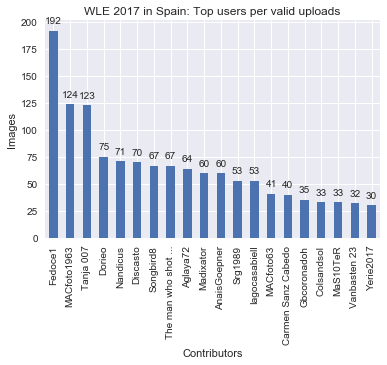

In [20]:
ax = authors_with_code \
        .head(20) \
        .plot(kind='bar',
              title='WLE {0} in Spain: Top users per valid uploads'.format(YEAR))

ax.set_xlabel('Contributors')
ax.set_ylabel('Images')
rects = ax.patches
labels = authors_with_code.head(20).tolist()
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
    
plt.savefig("images/WLE{0} - Top authors.png".format(YEAR), 
            transparent=True, 
            bbox_inches='tight', 
            pad_inches=0, 
            dpi = (200)
           )

bot = UploadRobot("images/WLE{0} - Top authors.png".format(YEAR),
                  description = description.format(YEAR,
                                                   'Top 20 contributors to Wiki Loves Earth {0} in Spain per valid upload'.format(YEAR),
                                                   time.strftime("%Y-%m-%d")),
                  useFilename='WLE{0} - Top authors.png'.format(YEAR),
                  keepFilename=True,
                  verifyDescription=False,
                  ignoreWarning=True)
if update_images :
    bot.run()

In [21]:
authors_with_site = authors_df["count_sci"].sort_values(ascending=False)
authors_with_site.rename(lambda x: get_flickr_name(x), inplace=True)
authors_with_site.rename(lambda x: shortener(x, 20), inplace=True)

The suggested description is:
== {{int:filedesc}} ==
{{Information
|description={{en|Top 12 contributors to Wiki Loves Earth 2017 in Spain per site}}
|source={{own}}
|author=[[User:Discasto|Discasto]]
|date=2017-06-15
}

{{Created with Matplotlib}}

== {{int:license-header}} ==
{{self|cc-by-sa-4.0}}

[[Category:Photos by User:Discasto]]
[[Category:Wiki Loves Earth 2017 in Spain]]
Uploading file to commons:commons...
Upload successful.
Upload of WLE2017 - Top authors (2).png successful.

1 pages read
1 pages written
Script terminated successfully.


'WLE2017 - Top authors (2).png'

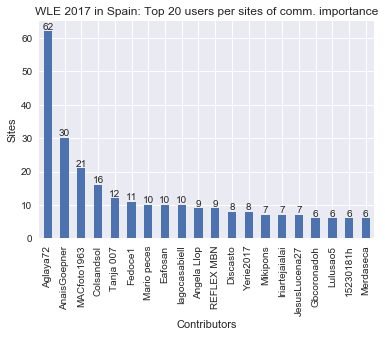

In [22]:
bx = authors_with_site \
        .head(20) \
        .plot(kind='bar', 
              title='WLE {0} in Spain: Top 20 users per sites of comm. importance'.format(YEAR),
              legend=False)
        
bx.set_xlabel('Contributors')
bx.set_ylabel('Sites')
rects = bx.patches
labels = authors_with_site.head(20).tolist()
for rect, label in zip(rects, labels):
    height = rect.get_height()
    bx.text(rect.get_x() + rect.get_width()/2, height, label, ha='center', va='bottom')
plt.savefig("images/WLE{0} - Top authors (2).png".format(YEAR), 
            transparent=True, 
            bbox_inches='tight', 
            pad_inches=0, 
            dpi = (200)
           )

bot = UploadRobot("images/WLE{0} - Top authors (2).png".format(YEAR),
                  description= description.format(YEAR,
                                                  'Top 12 contributors to Wiki Loves Earth {0} in Spain per site'.format(YEAR), 
                                                  time.strftime("%Y-%m-%d")),
                  useFilename='WLE{0} - Top authors (2).png'.format(YEAR),
                  keepFilename=True,
                  verifyDescription=False,
                  ignoreWarning=True)
if update_images :
    bot.run()

The suggested description is:
== {{int:filedesc}} ==
{{Information
|description={{en|Images uploaded to WLE 2017 in Spain by day}}
|source={{own}}
|author=[[User:Discasto|Discasto]]
|date=2017-06-15
}

{{Created with Matplotlib}}

== {{int:license-header}} ==
{{self|cc-by-sa-4.0}}

[[Category:Photos by User:Discasto]]
[[Category:Wiki Loves Earth 2017 in Spain]]
Uploading file to commons:commons...
Sleeping for 3.4 seconds, 2017-06-15 07:53:01
Upload successful.
Upload of WLE2017 - Uploads.png successful.

1 pages read
1 pages written
Script terminated successfully.


'WLE2017 - Uploads.png'

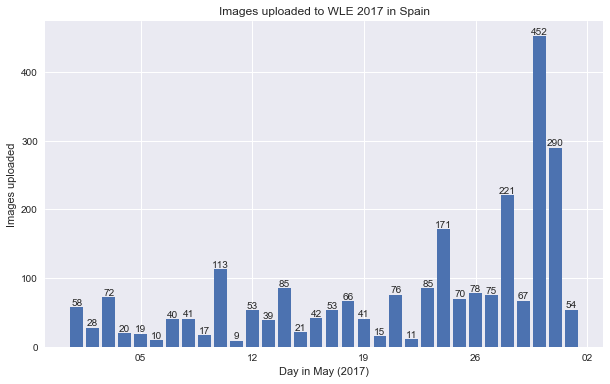

In [23]:
images_1_df = images_df['image_title'].resample('d').count()

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(images_1_df.index, images_1_df, align='center')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
ax.set_xlabel('Day in May ({0})'.format(YEAR))
ax.set_ylabel('Images uploaded')
ax.set_title('Images uploaded to WLE {0} in Spain'.format(YEAR))

rects = ax.patches
labels = images_1_df.tolist()
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height, label, ha='center', va='bottom')

plt.savefig("images/WLE{0} - Uploads.png".format(YEAR), 
            transparent=True, 
            bbox_inches='tight', 
            pad_inches=0, 
            dpi = (200)
           )

bot = UploadRobot("images/WLE{0} - Uploads.png".format(YEAR),
                  description = description.format(YEAR,
                                                   'Images uploaded to WLE {0} in Spain by day'.format(YEAR),
                                                   time.strftime("%Y-%m-%d")),
                  useFilename='WLE{0} - Uploads.png'.format(YEAR),
                  keepFilename=True,
                  verifyDescription=False,
                  ignoreWarning=True)
if update_images :
    bot.run()

In [24]:
# authors' gallery page
if valid_images_length < 4000:
    authors_with_sites  = images_df.groupby(['uploader'])

    author_gallery_text = u''
    for author, count in images_df["uploader"].value_counts().iteritems() :
        author_gallery_text += u'== %s ==\n\n' % (author)
        author_gallery_text += u"'''Total''': %d images.\n" % (count)
        author_gallery_text += u'<gallery>\n'
        pictures_per_author = list(authors_with_sites.get_group(author)["image_title"].unique())
        for _, value in enumerate(pictures_per_author) :
            author_gallery_text += u'%s\n' %(value)
        author_gallery_text += u'</gallery>\n\n'

    author_gallery_text += u'[[Category:Wiki Loves Earth {0} in Spain| Contributors]]'.format(YEAR)
    pb.output('Generating --> WLE {0} contributors gallery'.format(YEAR))

    authors_page = pb.Page(commons_site, GALLERY_PAGE_AUTHORS)
    authors_page.text = author_gallery_text
    pb.output('Publishing --> WLE {0} Authors gallery'.format(YEAR))
    authors_page.save(u"WLE Spain {0} gallery (per author)".format(YEAR))

Generating --> WLE 2017 contributors gallery
Publishing --> WLE 2017 Authors gallery
ERROR: Traceback (most recent call last):
  File "D:\Python\core\pywikibot\data\api.py", line 1954, in submit
    body=body, headers=headers)
  File "D:\Python\core\pywikibot\tools\__init__.py", line 1458, in wrapper
    return obj(*__args, **__kw)
  File "D:\Python\core\pywikibot\comms\http.py", line 322, in request
    r = fetch(baseuri, method, params, body, headers, **kwargs)
  File "D:\Python\core\pywikibot\comms\http.py", line 509, in fetch
    error_handling_callback(request)
  File "D:\Python\core\pywikibot\comms\http.py", line 396, in error_handling_callback
    raise request.data
ReadTimeout: HTTPSConnectionPool(host='commons.wikimedia.org', port=443): Read timed out. (read timeout=45)

Page [[Commons:Wiki Loves Earth 2017 in Spain/Contributors]] saved


In [25]:
# summaries for further use in templates
sci_images_length = authors_df['count_images_sci'].sum()
authors_length = len(authors_df)
communities_length = images_df[images_df["community"] != u'']["community"].nunique()
sites_length = len(images_df[images_df["name"] != u'']["name"].value_counts())

In [36]:
authors_df.sort_values(['count_images'], ascending=False, inplace=True)

statisticts_text = u''

template = u"""{| align=right
|[[File:WLE Austria Logo (transparent).svg|200px|link=]]
|- 
| style="text-align:center; font-family:arial black; font-size:200%; color:grey" | {{LangSwitch| es=España|ca=Espanya|en=Spain}}&nbsp;&nbsp;&nbsp;
|}

Welcome to the statistics of the '''Wiki Loves Earth ${year} in Spain''' contest. Below you will find information about the 
number of uploaded images, the contributors and the [[:en:Site of Community Importance|sites]] of community importance the 
pictures belong to. Enjoy!!!

== Executive summary ==

* '''Main category''': [[:Category:Images from Wiki Loves Earth ${year} in Spain|Images from Wiki Loves Earth ${year} in Spain]].
* '''Total (images)''': ${images_length}.
** '''Valid images''': ${valid_images_length}.
** '''Images from a site of community importance''': ${sci_images_length}.
** '''Quality Images''': ${qi_list_length} ([[${gallery_featured_articles}|see gallery]]).
* '''Total (sites of community importance)''': ${sites_length}.
* '''Total (contributors)''': ${authors_length}.
* '''Statistics generation date''': {{subst:CURRENTTIME}} UTC, {{subst:CURRENTMONTHNAME}} {{subst:CURRENTDAY}}, {{subst:CURRENTYEAR}}.

== Participants ==
The images below show the 20 top contibutors considering valid uploads (left) and number of sites of community importance (right).

{|
|-
| [[File:WLE${year} - Top authors.png|frameless|right|x500px|Top 20 contributors to Wiki Loves Earth ${year} in Spain per valid uploads.]]
| [[File:WLE${year} - Top authors (2).png|frameless|right|x450px|Top 12 contributors to Wiki Loves Earth ${year} in Spain per site.]]
|}

Next, the list of all the contributors, the uploaded images and the sites of community importance with a picture are shown:

<center>
{| class="wikitable sortable" style="width:80%; font-size:89%; margin-top:0.5em;"
|- valign="middle"
! style = "width: 25%;" | Author <small>(contributions to WLE ${year}: gallery, category)</small><br/><small>(registration time)</small>
! style = "width: 15%;" | Uploaded images (total)
! style = "width: 15%;" | Uploaded images (from a site of community importance)
! style = "width: 45%;" | Contributed to distinct SCIs (code, name)<br/>(number of per user distinct SCIs)
<%!
import datetime
%>
<%
def assemble_sci (codes) :
    if len(codes) == 0 :
        return ''
    else :
        code_name = list()
        for i, code in enumerate(codes) :
            code_name.append(u'[http://natura2000.eea.europa.eu/Natura2000/SDF.aspx?site={0} {0}] ({1})'.format(code, unicode(sci_df[sci_df["code"] == code]["name"].iloc[0], 'utf-8', 'replace')))
        return '<br/>'.join(code_name)

def get_reg_date (days, year) :
    if days == -1 :
        result = u"(from Flickr, no registration)"
    elif days == 3650 :
        result = u"(too old, no registration date available)"
    else :
        start_datetime =  datetime.datetime(year, 6, 1)
        registration_datetime = start_datetime - datetime.timedelta(days=days+1)
        result = u"(registered on {0})".format(registration_datetime.strftime("%Y-%m-%d"))
    return result
    
def get_user_link (name):
    if 'flickr' in name:
        result = u"[{0}]".format(name)
    else :
        result = u"{{{{u|{0}}}}}".format(name)
    return result
    
def get_category_link (name):
    if 'flickr' in name:
        result = u"{0} (flickr)".format(name.split(' ')[1])
    else :
        result = name
    return result

%>
% for index, row in authors_df.iterrows() :
|-
% if valid_images_length < 4000:
| ${get_user_link(index)} ([[Commons:Wiki Loves Earth ${year} in Spain/Contributors#${index}|gallery]], [[:Category:Images from Wiki Loves Earth ${year} in Spain by ${get_category_link(index)}|category]])<br/><small>${get_reg_date(row['registration'], year)}</small>
% else :
| ${get_user_link(index)} ([[:Category:Images from Wiki Loves Earth ${year} in Spain by ${get_category_link(index)}|category]])<br/><small>${get_reg_date(int(row['registration']), year)}</small>
% endif
| align="center" | ${row['count_images']}
| align="center" | ${row['count_images_sci']}
| align="center" | ${assemble_sci (row['codes'])}<br/>('''${row['count_sci']}''')
% endfor
|-
! Total: ${authors_length} contributors
! align="center" | ${images_length} pictures
! align="center" | ${authors_df['count_images_sci'].sum()} pictures (from<br/>a site of community importance)
! align="center" | ${sites_length} sites of<br/>community importance
|}
</center>

"""
vars = {
    "images_length": total_images_length,
    "qi_list_length": len(QI_list),
    "gallery_featured_articles": GALLERY_FEATURED_ARTICLES,
    "authors_df": authors_df,
    "sci_df": sci_df,
    "valid_images_length": valid_images_length,
    "sci_images_length": sci_images_length,
    "authors_length": authors_length,
    "sites_length": sites_length,
    "year": YEAR
}
t = Template(template)
statisticts_text += t.render(**vars)

In [37]:
authors_df = authors_df[authors_df.index.str.startswith('https') == False]
new_authors = authors_df[authors_df["registration"] < 46]["count_images"]
new_authors = new_authors.sort_index()

template = u"""===New contributors===
'''Number of contributors registered during (or just before) the contest''': '''${len(new_authors)}'''.
<%
def get_user_link (name):
    if 'flickr' in name:
        result = u"[{0}]".format(name)
    else :
        result = u"{{{{u|{0}}}}}".format(name)
    return result
%>
{| border = 0
|-
% for author, count in new_authors.iteritems() :
% if loop.index%(len(new_authors)/3) == 0 :
|
% endif
*${get_user_link(author)} (${count} pictures)
% endfor
|}
"""
vars = {
    "new_authors": new_authors
}
t = Template(template)
statisticts_text += t.render(**vars)

In [38]:
template = u"""=== Per-day contributions chart ===
<br clear="all"/>
[[File:WLE${year} - Uploads.png|frameless|center|x600px|Daily evolution of contributions to Wiki Loves Earth ${year} in Spain.]]

"""
vars = {
    "year": YEAR
}
t = Template(template)
statisticts_text += t.render(**vars)

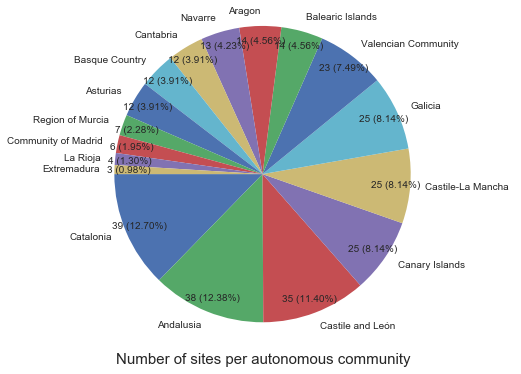

In [41]:
sites_per_community = images_df[images_df["community"] != u''].groupby(['community'])['code'].nunique().sort_values(ascending=False)

ax = sites_per_community.plot(kind="pie",
                              autopct=lambda p: '{:.0f} ({:.2f}%)'.format(p * sites_per_community.sum() / 100, p),
                              startangle=180,
                              legend=False,
                              pctdistance=0.9,
                              labeldistance=1.1,
                              radius=2)
ax.axis("equal")
ax.set_ylabel('')
plt.rcParams["figure.figsize"] = [9.0, 6.0]
plt.title('Number of sites per autonomous community', position=(0.5,-0.1), fontsize=15)
plt.savefig("WLE {0} - Sites per autonomous community.png".format(YEAR), 
            transparent=True, 
            bbox_inches='tight', 
            pad_inches=0, 
            dpi = (200)
           )

bot = UploadRobot("WLE {0} - Sites per autonomous community.png".format(YEAR),
                  description= description.format(YEAR,
                                                  'Sites of community importance per autonomous community in WLE {0}'.format(YEAR), 
                                                  time.strftime("%Y-%m-%d")),
                  useFilename='WLE {0} - Sites per autonomous community.png'.format(YEAR),
                  keepFilename=True,
                  verifyDescription=False,
                  ignoreWarning=True)
if update_images :
    bot.run()

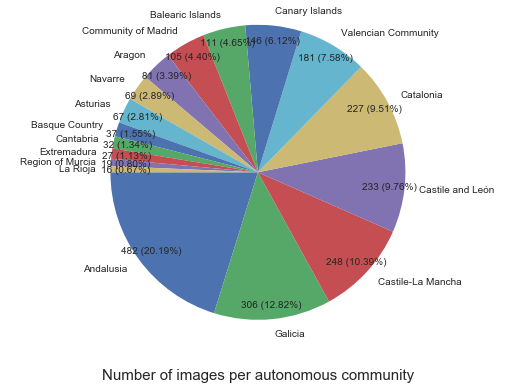

In [42]:
images_per_community = images_df[images_df["community"] != u''].groupby(['community']).agg('count')["image_title"].sort_values(ascending=False)

'''remaining_total = 0
for ind, val in images_per_community.iteritems():
    if val<12.0 :
        remaining_total += val
        images_per_community.drop(ind, inplace=True)

images_per_community = images_per_community.append(pd.Series([remaining_total], index=['Rest']))'''

ax = images_per_community.plot(kind="pie",
                               autopct=lambda(p): '{:.0f} ({:.2f}%)'.format(p * images_per_community.sum() / 100, p), 
                               startangle=180,
                               legend=False,
                               pctdistance=0.9,
                               labeldistance=1.1,
                               radius=2)
ax.axis("equal")
ax.set_ylabel('')
plt.rcParams["figure.figsize"] = [9.0, 6.0]
plt.title('Number of images per autonomous community', position=(0.5,-0.15), fontsize=15)
plt.savefig("WLE {0} - Images per autonomous community.png".format(YEAR),
            transparent=True,
            bbox_inches='tight',
            pad_inches=0,
            dpi = (200)
           )

bot = UploadRobot("WLE {0} - Images per autonomous community.png".format(YEAR),
                  description= description.format(YEAR, 
                                                  'Images per autonomous community in WLE {0}'.format(YEAR), 
                                                  time.strftime("%Y-%m-%d")),
                  useFilename='WLE {0} - Images per autonomous community.png'.format(YEAR),
                  keepFilename=True,
                  verifyDescription=False,
                  ignoreWarning=True)
if update_images :
    bot.run()

In [43]:
sites = images_df[images_df["code"].str.startswith('ES')] \
                                                        .groupby(['name', 'code', 'community', 'commons_cat']) \
                                                        .size() \
                                                        .sort_values(ascending=False)

template = u"""==Sites of Community Importance==

{|
|-
| [[File:WLE ${year} - Sites per autonomous community.png |frameless|right|x400px|Sites with picture by autonomous community.]]
| [[File:WLE ${year} - Images per autonomous community.png|frameless|right|x410px|Images by autonomous community.]]
|}
<center>
{| class="wikitable sortable" style="width:60%; font-size:89%; margin-top:0.5em;"
|- valign="middle"
! width="60%" | Site of Community Importance<br/>(Commons category)
! width="20%" | Autonomous community
! width="20%" | Uploaded images
% for index, value in sites.iteritems():
|-
% if len(index[3]) > 0 :
| '''${index[0]}''' ([http://natura2000.eea.europa.eu/Natura2000/SDF.aspx?site=${index[1]} ${index[1]}])<br/><small>'''Commons category''': [[:Category:${index[3]}|${index[3]}]]</small>
% else :
| '''${index[0]}''' ([http://natura2000.eea.europa.eu/Natura2000/SDF.aspx?site=${index[1]} ${index[1]}])
% endif
| align="center" | ${index[2]}
% if valid_images_length < 4000:
| align="center" | ${value}<br/>(see [[Commons:Wiki Loves Earth ${year} in Spain/SCIs#${index[0]} (${index[1]})|gallery]], [[:Category:Images of site of community importance with code ${index[1]} from Wiki Loves Earth ${year} in Spain|category]])
% else :
| align="center" | ${value}<br/>(see [[:Category:Images of site of community importance with code ${index[1]} from Wiki Loves Earth ${year} in Spain|category]])
% endif
% endfor
|-
! '''Total''': ${sites_length}/${sci_df.count()['code']} sites (${round(float(sites_length)*100 / float(sci_df.count()['code']), 2)}%)
! ${communities_length}
! ${sci_images_length}
|}
</center>

"""

vars = {
    "valid_images_length": valid_images_length,
    "sites": sites,
    "sci_df": sci_df,
    "sites_length": sites_length,
    "communities_length": communities_length,
    "sci_images_length": sci_images_length,
    "year": YEAR
}
t = Template(template)
statisticts_text += t.render(**vars)

In [44]:
template = u"""==Coverage==
Statistics on coverage describe the ratio of sites of community importance in the annexes
in the Spanish Wikipedia with Commons categories and/or images.
<center>
{| class="wikitable sortable" style="width:55%; font-size:89%; margin-top:0.5em;"
|- valign="middle"
! Autonomous Community
! Sites of Community importance (total)
! Sites (in annexes)<br/> with Commons category
! Sites (in annexes)<br/> with image
<%
    def get_color (grade) :
        if grade < 10.0 :
            percentage_color = 'ff6666'
        elif grade < 30.0 :
            percentage_color = 'ffb366'
        elif grade < 50.0 :
            percentage_color = 'ffff66'
        elif grade < 70.0 :
            percentage_color = 'd9ff66'
        elif grade < 90.0 :
            percentage_color = '66ff66'
        else :
            percentage_color = '668cff '
        return percentage_color
%>
% for name, group in grouped:
<%
    percentage_sites_with_cat = float (group.count()['commons_cat']*100.0/float(group.count()['community']))
    percentage_sites_with_image = float (group.count()['image']*100.0/float(group.count()['community']))
%>
|-
| [[:es:${annexes[name][0]}|${annexes[name][1]}]]
| align="center" | ${group.count()['community']}
| align="center" bgcolor="#${get_color(percentage_sites_with_cat)}" | ${group.count()['commons_cat']} (${round(percentage_sites_with_cat, 2)}%)
| align="center" bgcolor="#${get_color(percentage_sites_with_image)}" | ${group.count()['image']} (${round(percentage_sites_with_image, 2)}%)
% endfor
|-
| Total
| align="center" | ${sci_df.count()['code']}
| align="center" bgcolor="#${get_color(float (sci_df.count()['commons_cat']*100.0/float(sci_df.count()['community'])))}" | ${sci_df.count()['commons_cat']} (${round((float (sci_df.count()['commons_cat'])*100) / float (sci_df.count()['community']), 2)}%)
| align="center" bgcolor="#${get_color(float (sci_df.count()['image']*100.0/float(sci_df.count()['community'])))}" | ${sci_df.count()['image']} (${round((float (sci_df.count()['image'])*100) / float (sci_df.count()['community']), 2)}%)
|}
</center>
"""

vars = {
    "grouped": sci_df.groupby(['community']),
    "sci_df": sci_df,
    "annexes": annexes
}
t = Template(template)
statisticts_text += t.render(**vars)

In [45]:
dict_by_article = {item[0]: item[1] for item in sorted_by_article}
dict_by_wiki    = {item[0]: item[1] for item in sorted_by_wiki}

template = u"""==Image usage==
<center>
{| class="wikitable sortable" style="width:50%; font-size:89%; margin-top:0.5em;"
|- valign="middle"
! width="50%" | Wikimedia project
! width="25%" | WLE ${year} images used
! width="25%" | Articles with WLE ${year} images
% for item in sorted_by_article :
|-
| ${item[0]}
| align="center" | ${dict_by_wiki[item[0]]}
| align="center" | ${dict_by_article[item[0]]}
% endfor
|-
| Any Wikimedia project
| align="center" | '''${usage_counter}''' (${"{0:.2f}".format(100.0 * (float(usage_counter) / float(images_length)))}%)
| align="center" | '''${sum(dict_by_article.values())}'''
|}
</center>

== See also ==

* [[Commons:Wiki Loves Earth in Spain/Stats|Complete WLE in Spain statistics]]

[[Category:Wiki Loves Earth ${year} in Spain| Stats]]
[[Category:Statistics of Wiki Loves Earth in Spain| ${year}]]
"""
vars = {
    "images_length": total_images_length,
    "usage_counter": usage_counter,
    "dict_by_wiki": dict_by_wiki,
    "dict_by_article": dict_by_article,
    "sorted_by_article": sorted_by_article,
    "year": YEAR
}
t = Template(template)
statisticts_text += t.render(**vars)

In [46]:
stats_page = pb.Page(commons_site, STATISTICS_PAGE)
stats_page.text = statisticts_text
pb.output('Publishing --> WLE {0} Statistics'.format(YEAR))
#print statisticts_text
stats_page.save(u"WLE Spain {0} statistics".format(YEAR))

Publishing --> WLE 2017 Statistics
Sleeping for 8.9 seconds, 2017-06-15 08:52:29
Page [[Commons:Wiki Loves Earth 2017 in Spain/Stats]] saved


In [35]:
# sites gallery
if valid_images_length < 4000:
    site_gallery_text = u'== No valid site ==\n\n'
    site_gallery_text += u'<gallery>\n'
    for index, row in images_df[images_df['code']!= u''].iterrows() :
        site_gallery_text += u'%s\n' % (row['image_title'])
    site_gallery_text += u'</gallery>\n\n'

    groupby = images_df[images_df['code']!= u''].groupby(['code', 'name'])
    groupby_tuples = [(index, len(item)) for index, item in groupby]
    sorted_tuples = sorted(groupby_tuples, key=lambda x: x[1], reverse=True)
    sorted_indices = [x[0] for x in sorted_tuples]
    for index in sorted_indices:
        site_gallery_text += u'== %s (%s) ==\n' % (index[1], index[0])
        site_gallery_text += u'<gallery>\n'
        item = groupby.get_group(index)
        for i, value in item["image_title"].iteritems() :
            site_gallery_text += u'%s\n' % (value)
        site_gallery_text += '</gallery>\n\n'

    pb.output('Generating --> WLE {0} site gallery'.format(YEAR))
    site_gallery_text += u'[[Category:Wiki Loves Earth {0} in Spain| Sites]]'.format(YEAR)

    sites_page = pb.Page(commons_site, GALLERY_PAGE_SITES)
    sites_page.text = site_gallery_text
    pb.output('Publishing --> WLE {0} site gallery'.format(YEAR))
    sites_page.save(u"WLE Spain {0} gallery (per site)".format(YEAR))

Generating --> WLE 2017 site gallery
Publishing --> WLE 2017 site gallery
Sleeping for 5.7 seconds, 2017-06-15 07:54:55
Page [[Commons:Wiki Loves Earth 2017 in Spain/SCIs]] saved
